/var/folders/fd/p9kv0qdj1xxg3_yflhhzj1b80000gn/T/ipykernel_22491/3908948113.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(x_line, pooled.params[0] + pooled.params[1] * x_line,


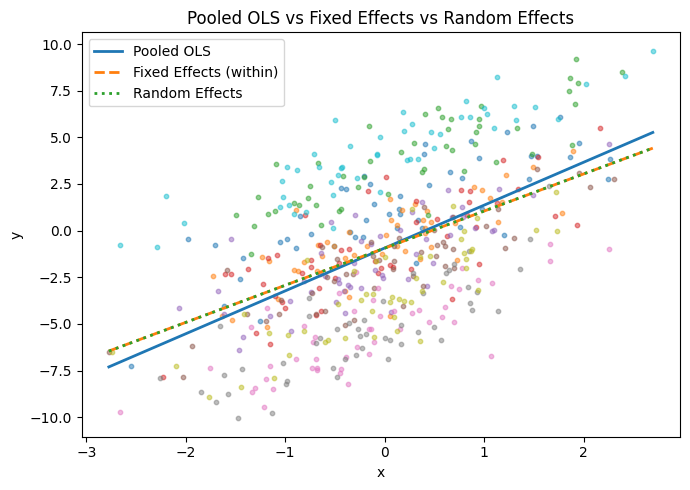

True slope           : 2.0
Pooled OLS slope     : 2.2973885481867278
Fixed Effects slope  : 1.988023790309764
Random Effects slope : 1.989408935198329


/var/folders/fd/p9kv0qdj1xxg3_yflhhzj1b80000gn/T/ipykernel_22491/3908948113.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Pooled OLS slope     :", pooled.params[1])


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

np.random.seed(0)                         # 再現性

# -----------------------------
# 1. 擬似データを作成
# -----------------------------
n_groups      = 10       # 個体（企業等）の数
n_per_group   = 50       # 各個体の時点数
beta_true     = 2.0      # 真の傾き
sigma_alpha   = 3.0      # 個体固有効果の分散
sigma_eps     = 1.5      # 誤差項の分散

groups = np.repeat(np.arange(n_groups), n_per_group)
x      = np.random.normal(size=n_groups * n_per_group)

# ---- 修正ここから ----
# グループ平均 x̄_i を求める（長さ n_groups）
x_bar_g = np.array([x[groups == g].mean() for g in range(n_groups)])

# α_i を生成（x̄_i と相関させたいので 0.5 * x̄_i を足す）
alpha_g = 0.5 * x_bar_g + np.random.normal(scale=sigma_alpha, size=n_groups)

# 各観測に対応する α を割り当て
y = beta_true * x + alpha_g[groups] + np.random.normal(scale=sigma_eps, size=len(x))
# ---- 修正ここまで ----

df = pd.DataFrame({"y": y, "x": x, "group": groups})

# -----------------------------
# 2. 各推定量を計算
# -----------------------------
# (a) Pooled OLS
pooled = sm.OLS(df["y"], sm.add_constant(df["x"])).fit()

# (b) 固定効果 (Within)
df["y_dm"] = df["y"] - df.groupby("group")["y"].transform("mean")
df["x_dm"] = df["x"] - df.groupby("group")["x"].transform("mean")
fe         = sm.OLS(df["y_dm"], df["x_dm"]).fit()
slope_fe   = fe.params["x_dm"]
intercept_fe = df["y"].mean() - slope_fe * df["x"].mean()   # 描画用

# (c) ランダム効果 (Random Intercept)
re_mod = MixedLM(df["y"], sm.add_constant(df["x"]), groups=df["group"])
re_res = re_mod.fit()
intercept_re = re_res.params["const"]
slope_re = re_res.params["x"]

# -----------------------------
# 3. 図を描く
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 5))

# グループごとに散布図
for g in range(n_groups):
    idx = df["group"] == g
    ax.scatter(df.loc[idx, "x"], df.loc[idx, "y"], alpha=0.5, s=10)

# 回帰線
x_line = np.linspace(df["x"].min(), df["x"].max(), 100)
ax.plot(x_line, pooled.params[0] + pooled.params[1] * x_line,
        label="Pooled OLS", linewidth=2)
ax.plot(x_line, intercept_fe + slope_fe * x_line,
        label="Fixed Effects (within)", linewidth=2, linestyle="--")
ax.plot(x_line, intercept_re + slope_re * x_line,
        label="Random Effects", linewidth=2, linestyle=":")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Pooled OLS vs Fixed Effects vs Random Effects")
ax.legend()
plt.tight_layout()
plt.show()

print("True slope           :", beta_true)
print("Pooled OLS slope     :", pooled.params[1])
print("Fixed Effects slope  :", slope_fe)
print("Random Effects slope :", slope_re)

In [4]:
# re_res.params

const       -0.939746
x            1.989409
Group Var    4.529698
dtype: float64